In [1]:
from statistics import LinearRegression

import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
from audiosegment import AudioSegment
from sklearn.model_selection import train_test_split, GridSearchCV
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import torch.nn.functional as F
from torchvision.transforms import Compose
import random
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression

In [2]:
X = np.array([[1,2],[3,3],[4,9],[10, 12],[8,3],[2,11],[18,2],[1,4],[2,5],[2,6],[10,12],[0,5],[8,9]])
y = np.dot(X, [1,2])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg = LinearRegression().fit(X_train,y_train)
print(reg.predict(X_test).astype(int))
print(y_test)

[ 5 34 26]
[ 5 34 26]


In [3]:
# waveform function for me to not bang my keyboard
def disp_waveform(signal,title='', sr=None, color='blue'):
    plt.figure(figsize=(7,2))
    plt.title(title)
    return librosa.display.waveshow(signal, sr=sr, color=color)

In [4]:
import noisereduce as nr

def signum(x):
    return 1 if x>0 else -1

def isolator(signal, sample_rate, n_fft, hop_length, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    denoised_signal = nr.reduce_noise(signal, sr=sample_rate)
    denoised_signal_boosted = np.where((np.abs(denoised_signal)>.04) & (np.abs(denoised_signal)<.4), (0.4-denoised_signal) * 1.15, denoised_signal)
    if show:
        disp_waveform(denoised_signal, 'signal waveform DENOISED', sr=sample_rate)
        disp_waveform(signal, 'signal waveform NOISED', sr=sample_rate)
        disp_waveform(denoised_signal_boosted, 'signal waveform DENOISED n BOOSTED', sr=sample_rate)
    signal = denoised_signal
    fft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    norm = np.linalg.norm(energy)
    energy = energy/norm
    # -- energy'
    threshed = energy > threshold
    # -- peaks'
    if show:
        disp_waveform(threshed.astype(float), sr=sample_rate)
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*hop_length) + n_fft//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            # strokes.append(torch.tensor(keystroke)[None, :])
            # keystroke = transform(keystroke)
            if len(keystroke) >= before + after:
                strokes.append(keystroke)
                if show and len(strokes) <=5:
                    disp_waveform(keystroke, title=f'keystroke {len(strokes)}', sr=sample_rate)
                prev_end = timestamp+after
    return strokes

In [5]:
# Constants we actually need for the task
original = True
concat = False
complete_set = list('1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-')
original_set = list('1234567890QWERTYUIOPASDFGHJKLZXCVBNM')
if original:
    # ORIGINAL DATA SET
    MBP_AUDIO_DIR, labels, audiostr = '../Dataset-for-Binary/base-audio/', list('1234567890QWERTYUIOPASDFGHJKLZXCVBNM'), 'audio_'
    keys = [audiostr + k + '.wav' for k in labels]
    N_FFT, HOP_LENGTH, BEFORE, AFTER = 1024, 225, 2400, 12000
    MBP_AUDIO_DIR_2, labels_2, audiostr = '../Dataset-custom-audio/base-audio-denoised-normalized/', list('1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'), ''
    keys_2 = [audiostr + k + '.wav' for k in labels_2]
    N_FFT_2, HOP_LENGTH_2, BEFORE_2, AFTER_2 = 1024, 225, 2200, 11000
else:
    # CUSTOM DATA SET
    MBP_AUDIO_DIR, labels, audiostr = '../Dataset-custom-audio/base-audio-denoised-normalized/', list('1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'), ''
    keys = [audiostr + k + '.wav' for k in labels]
    N_FFT, HOP_LENGTH, BEFORE, AFTER = 1024, 225, 2200, 11000
    MBP_AUDIO_DIR_2, labels_2, audiostr = '../Dataset-for-Binary/base-audio/', list('1234567890QWERTYUIOPASDFGHJKLZXCVBNM'), 'audio_'
    keys_2 = [audiostr + k + '.wav' for k in labels_2]
    N_FFT_2, HOP_LENGTH_2, BEFORE_2, AFTER_2 = 1024, 225, 2400, 12000

# keys list
data_dict = {'Key':[], 'File':[]}
data_dict_t= {'Key':[], 'File':[]} #for custom audio testing

# device agnostic to os
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# constants for isolator

(513, 2257)
(507801,)


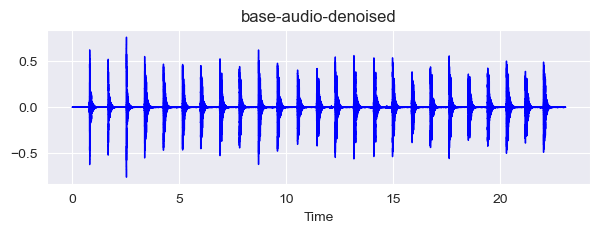

In [6]:
samples, sr = librosa.load(MBP_AUDIO_DIR+'audio_0.wav')
disp_waveform(samples, 'base-audio-denoised', sr=sr)
print(librosa.stft(samples, n_fft=1024, hop_length=225).shape)
print(samples.shape)

In [7]:
def create_dataset(n_fft, hop_length, before, after, keys, audio_dir, curr_labels, prom=0.2391, original=True):
    data_dict = {'Key':[], 'File':[]}
    for i, File in enumerate(keys):
        loc = audio_dir + File
        samples, sr = librosa.load(loc)
        show = (File[6 if original else 0] == '0')
        strokes = isolator(samples, sr, n_fft, hop_length, before, after, prom, show)
        if show:
            print(f'Length strokes: {len(strokes)}')
        label = [curr_labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace = True)
    
    return df

Length strokes: 25


/var/folders/dr/8bpx1vc91zq76n48xvq00vkr0000gn/T/ipykernel_1886/843507350.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Key': mapper}, inplace = True)


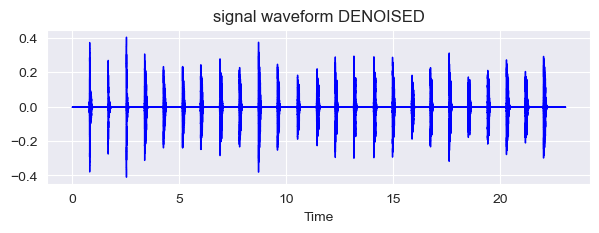

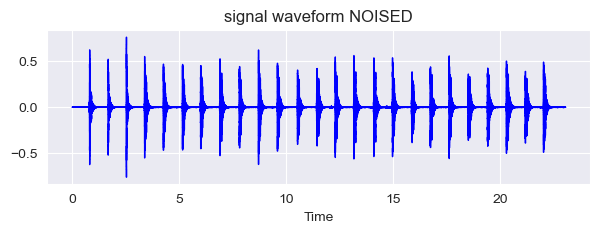

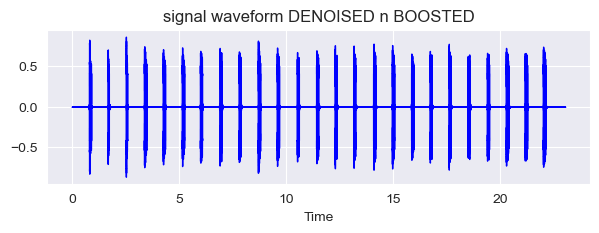

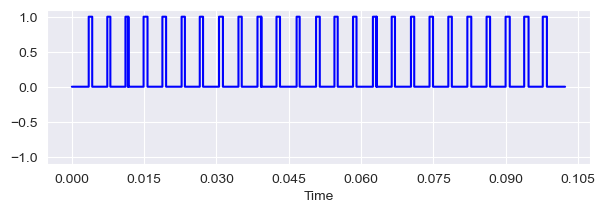

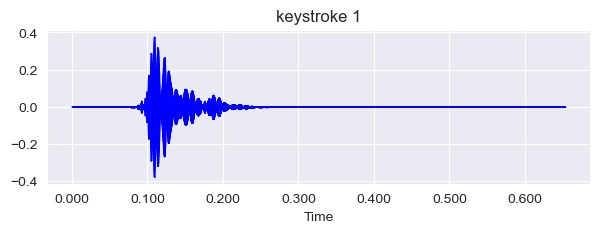

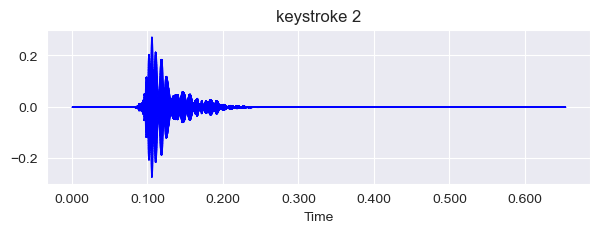

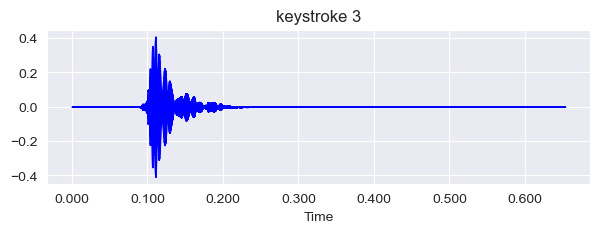

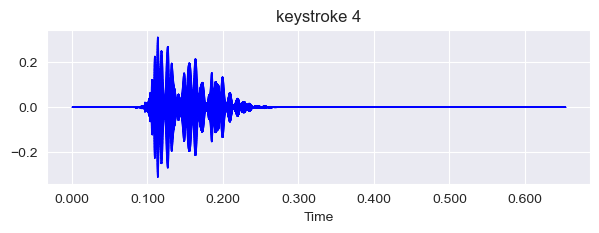

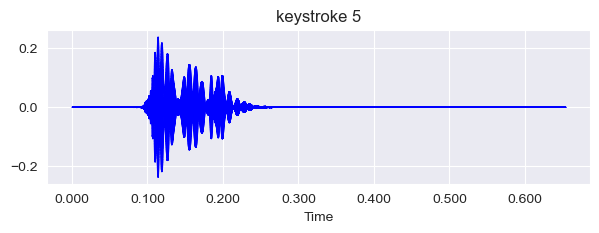

In [8]:
mbp_dataset = create_dataset(N_FFT, HOP_LENGTH, BEFORE, AFTER, keys, MBP_AUDIO_DIR, labels, prom=0.004, original=original)
if concat:
    mbp_dataset_2 = create_dataset(N_FFT_2, HOP_LENGTH_2, BEFORE_2, AFTER_2, keys_2, MBP_AUDIO_DIR_2, labels_2, prom=0.004, original=not original)
    print(mbp_dataset)
    print(mbp_dataset_2)
    mbp_dataset = pd.concat([mbp_dataset, mbp_dataset_2])

In [9]:
mbp_dataset

,Key,File
0,0,"[-1.9765257e-12, -7.5266117e-13, -3.2800477e-1..."
1,0,"[3.1104875e-07, 2.8876556e-07, 4.8392434e-07, ..."
2,0,"[1.5262138e-05, 1.8472152e-05, 2.0566145e-05, ..."
3,0,"[0.0005208879, 0.0005132711, 0.0005245662, 0.0..."
4,0,"[0.0026841052, 0.0026423365, 0.002146231, 0.00..."
...,...,...
894,35,"[-4.2240548e-16, -5.0369344e-16, -9.124689e-15..."
895,35,"[1.859441e-13, 3.890408e-14, -1.4408323e-13, -..."
896,35,"[-5.2457052e-14, -3.180999e-15, 3.922354e-14, ..."
897,35,"[-1.24707805e-14, 4.8742065e-13, 6.7182094e-13..."


In [10]:
import time

def get_best_threshold(lim_start, lim_end, original):
    threshold_values = np.arange(lim_start, lim_end, 0.0005)
    max_thres_value = threshold_values[0]
    max_mean = 1
    min_rel_std = 100000
    for threshold_value in threshold_values:
        lengths = []
        for key in keys_s:
            sample, sr = librosa.load(f'{MBP_AUDIO_DIR}{"audio_" if original else ""}{key}.wav')
            lengths.append(len(isolator(sample, sr, 1024, 225, 2200, 11000, threshold_value)))
        print(f'Thres: {threshold_value:.4f}' , end=' ')
        mean = np.mean(lengths)
        rel_std = (np.std(lengths)/np.mean(lengths))*100
        if 38 <= mean <= 42:
            print(lengths)
        if rel_std < min_rel_std:
            min_rel_std = rel_std
            max_thres_value = threshold_value
            max_mean = mean
        print(f'threshold: {threshold_value:.4f}  /  mean: {mean:.2f}  /  rel std dev: {((np.std(lengths)/mean) *100):.3f}%  /  max: {np.max(lengths)}  /  min: {np.min(lengths)}')
    print(f'Min relative std: {min_rel_std:.4f} threshold value:  {max_thres_value:.4f} mean: {max_mean:.4f}')
    return max_thres_value

In [11]:
get_best_threshold(0.001, 0.2, original)

NameError: name 'keys_s' is not defined

In [12]:
import audiosegment

def get_audio_length(audio_path):
    audio = audiosegment.from_file(audio_path)
    return audio.duration_seconds

def convert_to_ms(t):
    return round(t*1000)

def get_audio_length_average(audio_path, keys):
    lengths = []
    for i, File in enumerate(keys):
        loc = audio_path + File
        length = get_audio_length(loc)
        print(f'File {loc} length: {length:2f}\n')
        lengths.append(length)
    average = np.mean(lengths)
    return convert_to_ms(average)

In [13]:
audio_samples = mbp_dataset['File'].values.tolist()
labels = mbp_dataset['Key'].values.tolist()

audioDataset = np.array(audio_samples, dtype = object)
print(audio_samples[0].shape)
mfcc = librosa.feature.mfcc(y=audio_samples[0], sr=44100) # shape: (n_mfcc, t)
print(mfcc.shape)
# labels = np.array(labels)

(14400,)
(20, 29)


In [14]:
def time_shift(samples):
    samples = samples.flatten()
    shift = int(len(samples) * 0.4) #Max shift (0.4)
    random_shift = random.randint(0, shift) #Random number between 0 and 0.4*len(samples)
    data_roll = np.roll(samples, random_shift)
    return data_roll

def masking(samples):
    num_mask = 2
    freq_masking_max_percentage=0.10
    time_masking_max_percentage=0.10
    spec = samples
    mean_value = spec.mean()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = mean_value

        time_percentage = random.uniform(0.0, time_masking_max_percentage)

        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = mean_value
    return spec

In [15]:
from skimage.transform import resize

class ToMelSpectrogram:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=1024, hop_length=225)
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)
        return torch.tensor(mel_spec_resized)


class ToMelSpectrogramMfcc:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=n_fft, hop_length=hop_length)
        mel_spec = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec))
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)

        return torch.tensor(mel_spec_resized)


class ToMfcc:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')
        
        mfcc_spec = librosa.feature.mfcc(y=samples, sr=44100)
        mfcc_spec = np.transpose(mfcc_spec)
        return torch.tensor(mfcc_spec)


In [16]:
transform = Compose([ToMelSpectrogram()])
transform_mfcc = Compose([ToMfcc()])

In [17]:
audio_samples = mbp_dataset['File'].values.tolist()
labels = mbp_dataset['Key'].values.tolist()

audio_samples_new = audio_samples.copy() # audio samples CNN
print(len(audio_samples))

for i, sample in enumerate(audio_samples):
    audio_samples_new.append(time_shift(sample))
    labels.append(labels[i])

# convert labels to a numpy array
labels = np.array(labels)
print(len(audio_samples_new))
print(len(labels))

(14400,)
(20, 29)
899
1798
1798


In [18]:
audioDatasetFin, audioDatasetFinMasking, audioDatasetMfcc, audioDatasetMfccMasking = [], [], [], []

for i in range(len(audio_samples_new)):
    transformed_sample = transform(audio_samples_new[i])
    transformed_mfcc = transform_mfcc(audio_samples_new[i])
    
    # CoAtNet part
    audioDatasetFin.append((transformed_sample, labels[i]))
    audioDatasetFinMasking.append((masking(transformed_sample), labels[i]))
    
    # masking part
    audioDatasetMfcc.append((transformed_sample, transformed_mfcc, labels[i]))
    audioDatasetMfccMasking.append((masking(transformed_sample), transformed_mfcc, labels[i]))


0


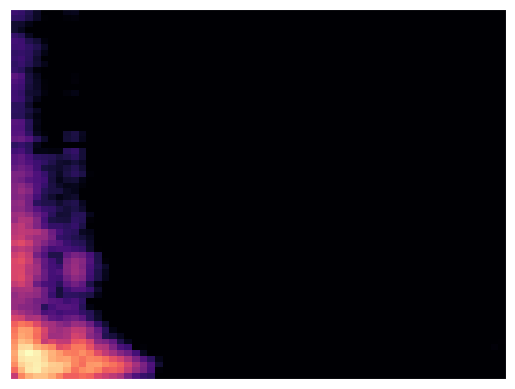

In [19]:
i = 6
mel_spec = librosa.feature.melspectrogram(y=audio_samples[i], sr=44100, n_mels=64, n_fft=1024, hop_length=225)
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max))
print(labels[i])

In [20]:
# check for lengths of datasets
len(audioDatasetMfcc), len(audioDatasetMfccMasking), len(audioDatasetFin), len(audioDatasetFinMasking)

(1798, 1798, 1798, 1798)

In [21]:
import time
from sklearn.base import BaseEstimator

class MfccLSTM(nn.Module, BaseEstimator):
    def __init__(self, num_epochs=500, patience=15):
        super(MfccLSTM, self).__init__()        
        self.num_epochs = num_epochs
        self.patience = patience
        
        hidden_size = 32
        input_size = 20
        dropout = 0.2 
        num_classes = 36
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.LazyLinear(128)
        self.final_lstm = nn.LSTM(1, 128, batch_first=True, proj_size=64)
        
        self.fc = nn.LazyLinear(num_classes)
    
    def forward(self, images, sequences):
        # must return shape (batch_size, num_classes) 
        # batch_size: right now is 16
        # num_classes: right now is 36
        x1 = self.conv(images)
        # print(f'input of first lstm: {sequences.shape[1:]}')
        out1, _ = self.lstm(sequences)
        out1_dp = self.dropout(out1)
        # print(f'output of first lstm: {out1_dp.shape[1:]}')
        # print(f'input of second lstm: {out1_dp[:, -1, :].shape[1:]}')
        out2, _ = self.lstm2(out1_dp[:, -1, :])
        out2_dp = self.dropout(out2)
        # print(f'output of second lstm: {out2_dp.shape[1:]}')
        x2 = self.fc2(self.fc1(out2_dp))
        x3 = torch.cat((x1, x2), 1)
        # print(f'output of concatenation: {x3.shape[1:]}')
        # x4 = self.fc3(x3)
        # # print(f'input final lstm: {x4[:,-1,:].shape[1:]}')
        # print(f'x4.shape: {x4.shape[1:]}')
        # x_final = self.final_lstm(x4)
        # # x = self.fc(final_out[:, -1, :])
        x = self.fc(x3)
        return x
    
    def fit(self, X, y):
        self._optimizer = optim.Adam(self.parameters(), lr=5e-4)
        # same training method but now inside the class
        model = self.to(device)
        
        # loss criterion
        criterion = nn.CrossEntropyLoss()
        
        # concatenate so it has the same shape as before
        dataset = np.concatenate((X, y), axis=1)
        train_set, val_set = train_test_split(dataset, test_size=0.2)
        train_loader = DataLoader(train_set, batch_size=16)
        val_loader = DataLoader(val_set, batch_size=16)
        
        best_val_acc, epochs_no_imp = 0, 0
        train_accuracies, val_accuracies = [], []
        
        for epoch in range(self.num_epochs):
            model.train()
            epoch_train_loss = 0.0
            correct_train = 0
            total_train = 0
            tic = time.perf_counter()
            
            for images, sequences, labels in train_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)
                
                self._optimizer.zero_grad()
        
                # converting labels to Long to avoid error "not implemented for Int"
                labels = labels.long()
                
                # Forward pass
                outputs = model(images, sequences)
                loss = criterion(outputs, labels)
                epoch_train_loss += loss.item() * images.size(0)
        
                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                
                # Backward pass
                loss.backward()
                self._optimizer.step()
            
            toc = time.perf_counter()
            time_taken = toc - tic
            
            epoch_train_loss /= len(train_loader.dataset)
            train_accuracy = correct_train / total_train
            train_accuracies.append(train_accuracy)
            
            # Evaluation of the model
            model.eval()
            total, correct = 0, 0
            
            for images, sequences, labels in val_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)
        
                outputs = model(images, sequences)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #
            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
            if (epoch + 1) % 5 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
                
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                epochs_no_imp = 0
                best_model_state = model.state_dict()  # Save the best model
            else:
                epochs_no_imp += 1
            if epochs_no_imp >= self.patience:
                print(f'Early stopping after {epoch+1} epochs')
                model.load_state_dict(best_model_state)  # Load the best model
                break
        return self
        
    def predict(self, X):
        images_test_set = [t[0] for t in X]
        sequences_test_set = [t[1] for t in X]
        
        images = torch.stack(images_test_set)
        sequences = torch.stack(sequences_test_set)
        images = images.to(device)
        sequences = sequences.to(device)
        model = self.to(device)
        model.eval()
        
        with torch.no_grad():
            outputs = model(images, sequences)
            _, predicted = torch.max(outputs.data, 1)
    
        pred = []
        keyss = '1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'
        phrase = predicted.tolist()
        for i in range(len(phrase)):
            pred.append(keyss[phrase[i]])
        pred_df = pd.DataFrame(pred)
        return np.squeeze(pred_df.to_numpy().T)

In [ ]:
from coatnet import CoAtNet as CoAtNetImp

num_blocks = [2, 2, 3, 5, 2]            # L
channels = [64, 96, 192, 384, 768]      # D

class CoAtNet(nn.Module, BaseEstimator):
    def __init__(self, num_epochs=500, patience=15):
        super(CoAtNet, self).__init__()    
        self.keys = '1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'
        self.model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(self.keys))
        self.num_epochs = num_epochs
        self.patience = patience
    
    def forward(self, x):
        return self.model(x)
    
    def fit(self, X, y):
        # concatenate so it has the same shape as before
        dataset = [(X[i], y[i]) for i in range(np.array(X).shape[0])]
        # dataset = np.concatenate((X, y), axis=1)
        train_set, val_set = train_test_split(dataset, test_size=0.2)
        train_loader, val_loader = DataLoader(train_set, batch_size=16), DataLoader(val_set, batch_size=16)

        # Initialize model, optimizer, and loss function
        self._optimizer = optim.Adam(self.model.parameters(), lr=5e-4)

        # same training method but now inside the class
        model = self.model.to(device)
        
        # loss criterion
        criterion = nn.CrossEntropyLoss()
        
        best_val_acc, epochs_no_imp = 0, 0
        train_accuracies, val_accuracies = [], []
        
        for epoch in range(self.num_epochs):
            model.train()
            epoch_train_loss = 0.0
            correct_train = 0
            total_train = 0
            tic = time.perf_counter()
            
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                self._optimizer.zero_grad()
        
                # converting labels to Long to avoid error "not implemented for Int"
                labels = labels.long()
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_train_loss += loss.item() * images.size(0)
        
                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                
                # Backward pass
                loss.backward()
                self._optimizer.step()
            
            toc = time.perf_counter()
            time_taken = toc - tic
            
            epoch_train_loss /= len(train_loader.dataset)
            train_accuracy = correct_train / total_train
            train_accuracies.append(train_accuracy)
            
            # Evaluation of the model
            model.eval()
            total, correct = 0, 0
            
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
        
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #
            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
            if (epoch + 1) % 5 == 0:
                print(f"Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
                
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                epochs_no_imp = 0
                best_model_state = model.state_dict()  # Save the best model
            else:
                epochs_no_imp += 1
            if epochs_no_imp >= self.patience:
                print(f'Early stopping after {epoch+1} epochs')
                model.load_state_dict(best_model_state)  # Load the best model
                break
        return self
    
    def predict(self, X):
        argnames=["x"]
        fin_dict = {}
        # create the list with each of the ith range tuples
        for i in range(len(X[0])-1):
            fin_dict[argnames[i]] = [t[i] for t in dataset]
            
        # torch.stack each one of the lists
        for key in fin_dict.keys():
            fin_dict[key] = torch.stack(fin_dict[key]).to(device)
        
        X = torch.tensor(np.array(X)).to(device)
        
        # model specifying
        model = self.model.to(device)
        model.eval()
        
        with torch.no_grad():
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
        
        pred = []
        # phrase = predicted.tolist()
        # for i in range(len(phrase)):
        #     pred.append(self.keys[phrase[i]])
        # 
        # pred_df = pd.DataFrame(pred)
        # return np.squeeze(pred_df.to_numpy().T)
        return predicted.tolist()

In [109]:
from sklearn.metrics import make_scorer

dataset = audioDatasetFin + audioDatasetFinMasking
X = [t[0] for t in audioDatasetFin]
X_masking = [t[0] for t in audioDatasetFinMasking]
y = [t[1] for t in audioDatasetFin]
y_masking = [t[1] for t in audioDatasetFinMasking]
print(np.array(X).shape)
first_el = dataset[0][0]
print(np.array(y+y_masking).shape)

param_grid = {
    'num_epochs': [500, 700, 1100],
    'patience': [55, 75, 100],
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0.0),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0.0),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0.0),
}

grid_search = GridSearchCV(CoAtNet(), param_grid, cv=5, scoring=scoring, refit=False, verbose=3)
# model = CoAtNet(patience=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
grid_search.fit(X_train + X_masking, y_train + y_masking)
print(np.array(X_train).shape)
print(np.array(y_train).shape)
# print(np.array(dataset).shape)
# print(np.concatenate((X_train, y_train), axis=3).shape)
# model.fit(X_train+X_masking, y_train+y_masking)
# print(f'Prediction: {model.predict(np.array(X_test)).shape}')
# final_labels_set = [original_set[ind] for ind in y_test]
# print(f'Labels: {np.array(final_labels_set).shape}')

(1798, 1, 64, 64)
(3596,)
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch [5/500], Train Loss: 1.5717, Train Accuracy: 0.5290, Val Accuracy: 0.4035, Iter Time: 6.80s
Epoch [10/500], Train Loss: 0.8844, Train Accuracy: 0.7488, Val Accuracy: 0.4865, Iter Time: 7.01s
Epoch [15/500], Train Loss: 0.6177, Train Accuracy: 0.8275, Val Accuracy: 0.5444, Iter Time: 6.89s
Epoch [20/500], Train Loss: 0.5037, Train Accuracy: 0.8628, Val Accuracy: 0.5888, Iter Time: 6.90s
Epoch [25/500], Train Loss: 0.5349, Train Accuracy: 0.8705, Val Accuracy: 0.5811, Iter Time: 7.03s
Epoch [30/500], Train Loss: 0.4122, Train Accuracy: 0.8879, Val Accuracy: 0.6120, Iter Time: 6.90s
Epoch [35/500], Train Loss: 0.3781, Train Accuracy: 0.9029, Val Accuracy: 0.6371, Iter Time: 7.16s
Epoch [40/500], Train Loss: 0.3255, Train Accuracy: 0.9145, Val Accuracy: 0.6023, Iter Time: 7.00s
Epoch [45/500], Train Loss: 0.2390, Train Accuracy: 0.9435, Val Accuracy: 0.6158, Iter Time: 6.90s
Epoch [50/500], Train Lo

In [115]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df = cv_results_df[["params", "mean_test_accuracy", "rank_test_accuracy", "mean_test_f1_weighted", "rank_test_f1_weighted", "mean_test_precision_weighted", "rank_test_precision_weighted", 
 "mean_test_recall_weighted", "rank_test_recall_weighted"]]
cv_results_df

,params,mean_test_accuracy,rank_test_accuracy,mean_test_f1_weighted,rank_test_f1_weighted,mean_test_precision_weighted,rank_test_precision_weighted,mean_test_recall_weighted,rank_test_recall_weighted
0,"{'num_epochs': 500, 'patience': 55}",0.732393,9,0.750796,9,0.807675,9,0.732393,9
1,"{'num_epochs': 500, 'patience': 75}",0.734218,8,0.752113,8,0.814005,6,0.734218,8
2,"{'num_epochs': 500, 'patience': 100}",0.776561,2,0.795984,1,0.840857,1,0.776561,2
3,"{'num_epochs': 700, 'patience': 55}",0.776869,1,0.788792,2,0.836768,2,0.776869,1
4,"{'num_epochs': 700, 'patience': 75}",0.744410,7,0.759896,7,0.812580,7,0.744410,7
5,"{'num_epochs': 700, 'patience': 100}",0.747840,5,0.760161,6,0.811625,8,0.747840,5
6,"{'num_epochs': 1100, 'patience': 55}",0.746896,6,0.760776,5,0.817040,4,0.746896,6
7,"{'num_epochs': 1100, 'patience': 75}",0.762976,3,0.774150,3,0.815274,5,0.762976,3
8,"{'num_epochs': 1100, 'patience': 100}",0.750309,4,0.765130,4,0.819910,3,0.750309,4


In [116]:
sorted_df = cv_results_df.sort_values(by=['rank_test_accuracy'])

for ind, row in sorted_df.iterrows():
    print(f'Rank: {row["rank_test_accuracy"]}')
    print(f'Params: {row["params"]}')
    print(f'Test accuracy: {row["mean_test_accuracy"]:.3f}', end=" / ")
    print(f'F1 Weighted: {row["mean_test_f1_weighted"]:.3f}', end=" / ")
    print(f'Recall Weighted: {row["mean_test_recall_weighted"]:.3f}', end=" / ")
    print(f'Precision Weighted: {row["mean_test_precision_weighted"]:.3f}', end="\n\n")

# best_params_list = grid_search.cv_results_['rank_test_accuracy']
# print(grid_search.cv_results_)
# print(best_params_list)
# print(best_params_list)
# print(best_params_list)
# print(grid_search.cv_results_["mean_test_accuracy"])
# 
# for i in best_params_list:
#     print(f'Parameter {i-1}: {grid_search.cv_results_["params"][i-1]}')
#     print(f'Mean Test accuracy: {grid_search.cv_results_["mean_test_accuracy"][i-1]:.3f}')
#     print(f'Std Test accuracy: {grid_search.cv_results_["std_test_accuracy"][i-1]:.3f}')
#     # print(f'Mean F1 weighted: {grid_search.cv_results_["mean_test_f1_weighted"][i-1]:.3f}')
#     # print(f'Mean Recall weighted: {grid_search.cv_results_["mean_test_recall_weighted"][i-1]:.3f}')
#     # print(f'Mean Precision weighted: {grid_search.cv_results_["mean_test_precision_weighted"][i-1]:.3f}')
#     print()

Rank: 1
Params: {'num_epochs': 700, 'patience': 55}
Test accuracy: 0.777 / F1 Weighted: 0.789 / Recall Weighted: 0.777 / Precision Weighted: 0.837

Rank: 2
Params: {'num_epochs': 500, 'patience': 100}
Test accuracy: 0.777 / F1 Weighted: 0.796 / Recall Weighted: 0.777 / Precision Weighted: 0.841

Rank: 3
Params: {'num_epochs': 1100, 'patience': 75}
Test accuracy: 0.763 / F1 Weighted: 0.774 / Recall Weighted: 0.763 / Precision Weighted: 0.815

Rank: 4
Params: {'num_epochs': 1100, 'patience': 100}
Test accuracy: 0.750 / F1 Weighted: 0.765 / Recall Weighted: 0.750 / Precision Weighted: 0.820

Rank: 5
Params: {'num_epochs': 700, 'patience': 100}
Test accuracy: 0.748 / F1 Weighted: 0.760 / Recall Weighted: 0.748 / Precision Weighted: 0.812

Rank: 6
Params: {'num_epochs': 1100, 'patience': 55}
Test accuracy: 0.747 / F1 Weighted: 0.761 / Recall Weighted: 0.747 / Precision Weighted: 0.817

Rank: 7
Params: {'num_epochs': 700, 'patience': 75}
Test accuracy: 0.744 / F1 Weighted: 0.760 / Recall Wei

In [42]:
dataset = audioDatasetFin + audioDatasetFinMasking
# X = np.array(dataset)[:, :1]
# y = np.array(dataset)[:, 2]
# print(X.shape)
# print(dataset[0])
X = [t[0] for t in dataset]
y = [t[1] for t in dataset]

param_grid = {
    'num_epochs': [500, 700, 1100],
    'patience': [10, 15, 20, 30, 50, 100],
}

grid_search = GridSearchCV(CoAtNet(), param_grid, cv=10, scoring=['accuracy', 'f1', 'precision', 'recall'], refit=False, verbose=3)

dataset = audioDatasetMfcc + audioDatasetMfccMasking
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y),test_size=0.2)

                                                    
print(X_train.shape)
print(y_train.shape)
grid_search.fit(X_train, y_train)

(2876, 1, 64, 64)
(2876,)
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END num_epochs=500, patience=10; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/10] END num_epochs=500, patience=10; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/10] END num_epochs=500, patience=10; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/10] END num_epochs=500, patience=10; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/10] END num_epochs=500, patience=10; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 6/10] END num_epochs=500, patience=10; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 7/10] END num_epochs=500, patience=10; accuracy: (test=nan) f1: (test=nan

KeyboardInterrupt: 

In [23]:
param_grid = {
    'num_epochs': [500, 700, 1100],
    'patience': [10, 15, 20, 30, 50, 100],
}
grid_search = GridSearchCV(MfccLSTM(), param_grid, cv=10, scoring=['accuracy', 'f1', 'precision', 'recall'], refit=False)

dataset = audioDatasetMfcc + audioDatasetMfccMasking
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
# print(X_train.shape)
grid_search.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ValueError: 
All the 180 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/var/folders/dr/8bpx1vc91zq76n48xvq00vkr0000gn/T/ipykernel_23867/3377303465.py", line 74, in fit
    dataset = np.concatenate((X, y), axis=1)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)


In [45]:
# Model architecture
class CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [46]:
import time

def train_cnnlstm_with_cross_val(dataset, num_epochs, model_name, device, num_classes=36, patience=10, random_state=42, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f'Fold {fold+1}/{n_splits}')
        
        # Split the dataset into training and validation sets
        train_set = Subset(dataset, train_idx)
        val_set = Subset(dataset, val_idx)
        train_loader = DataLoader(train_set, batch_size=16)
        val_loader = DataLoader(val_set, batch_size=16)
        
        # Initialize model, optimizer, and loss function
        model = MfccLSTM(input_size=20, hidden_size=32, num_classes=num_classes, output_size=64)
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=5e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_val_acc, epochs_no_imp = 0, 0
        train_accuracies, val_accuracies = [], []

        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0.0
            correct_train = 0
            total_train = 0
            tic = time.perf_counter()
            
            for images, sequences, labels in train_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                #converting labels to Long to avoid error "not implemented for Int"
                labels = labels.long()
                
                # Forward pass
                outputs = model(images, sequences)
                loss = criterion(outputs, labels)
                epoch_train_loss += loss.item() * images.size(0)

                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                
                # Backward pass
                loss.backward()
                optimizer.step()
            
            toc = time.perf_counter()
            time_taken = toc - tic
            
            epoch_train_loss /= len(train_loader.dataset)
            train_accuracy = correct_train / total_train
            train_accuracies.append(train_accuracy)
            
            # Evaluation of the model
            model.eval()
            total, correct = 0, 0
            for images, sequences, labels in val_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)

                outputs = model(images, sequences)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #
            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
            if (epoch + 1) % 5 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
                
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                epochs_no_imp = 0
                best_model_state = model.state_dict()  # Save the best model
            else:
                epochs_no_imp += 1
            if epochs_no_imp >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                model.load_state_dict(best_model_state)  # Load the best model
                break
        
        fold_results.append(best_val_acc) 
        print(f'Fold {fold+1} Best Validation Accuracy: {best_val_acc:.4f}')
    torch.save(model.state_dict(), model_name)
    print(f'Training final results: {fold_results}')
    
    return num_epochs, np.average(fold_results)

In [47]:
import time
from coatnet import CoAtNet as CoAtNetImp

num_blocks = [2, 2, 3, 5, 2]            # L
channels = [64, 96, 192, 384, 768]      # D

def train_coatnet_with_cross_val(dataset, num_epochs, model_name, device_external, num_classes=36, patience=10, random_state=42):
    train_set, val_set = train_test_split(dataset, test_size=0.2, random_state=random_state)
    train_loader, val_loader = DataLoader(train_set, batch_size=16), DataLoader(val_set, batch_size=16)
    
    # Initialize model, optimizer, and loss function
    model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=num_classes)
    device = torch.device(device_external) #default to mps
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc, epochs_no_imp = 0, 0
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0
        tic = time.perf_counter()
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
    
            labels = labels.long() # converting labels to Long to avoid error "not implemented for Int"
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item() * images.size(0)
    
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        toc = time.perf_counter()
        time_taken = toc - tic
        
        epoch_train_loss /= len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Evaluation of the model
        model.eval()
        total, correct = 0, 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
            
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            epochs_no_imp = 0
            best_model_state = model.state_dict()  # Save the best model
        else:
            epochs_no_imp += 1
        if epochs_no_imp >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            model.load_state_dict(best_model_state)  # Load the best model
            break
            
    torch.save(model.state_dict(), model_name)
    return epoch+1, best_val_acc

In [48]:
def predict_mfcc(dataset, model_path, device_external):
    images_test_set = [t[0] for t in dataset]
    sequences_test_set = [t[1] for t in dataset]
    
    images = torch.stack(images_test_set)
    sequences = torch.stack(sequences_test_set)
    device = torch.device(device_external) #default to mps
    images = images.to(device)
    sequences = sequences.to(device)
    model = MfccLSTM(input_size=20, hidden_size=32, num_classes=36, output_size=64)
    model = model.to(device)
    model.load_state_dict(torch.load(model_path,map_location=device))
    model.eval()
    
    with torch.no_grad():
        outputs = model(images, sequences)
        _, predicted = torch.max(outputs.data, 1)

    pred = []
    keyss = '1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'
    phrase = predicted.tolist()
    for i in range(len(phrase)):
        pred.append(keyss[phrase[i]])

    pred_df = pd.DataFrame(pred)
    return pred_df


def predict(dataset, model_obj, argnames, model_path, device_external):
    fin_dict = {}

    # create the list with each of the ith range tuples
    for i in range(len(dataset[0])-1):
        fin_dict[argnames[i]] = [t[i] for t in dataset]
        
    # specify device: default to mps
    device = torch.device(device_external) 
    
    # torch.stack each one of the lists
    for key in fin_dict.keys():
        fin_dict[key] = torch.stack(fin_dict[key]).to(device)
    
    # model specifying
    model = model_obj.to(device)
    model.load_state_dict(torch.load(model_path,map_location=device))
    model.eval()
    
    with torch.no_grad():
        outputs = model(**fin_dict)
        _, predicted = torch.max(outputs.data, 1)
    
    pred = []
    keyss = '1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'

    phrase = predicted.tolist()
    for i in range(len(phrase)):
        pred.append(keyss[phrase[i]])

    pred_df = pd.DataFrame(pred)
    return pred_df

In [49]:
def save_csv(model_name, num_epochs, description, accuracy, precision, recall, f1_score):
    csv_file_path = 'model_comparison.csv'
    
    # Read the existing CSV file into a DataFrame
    try:
        df = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        # If the file does not exist, create an empty DataFrame with the correct columns
        df = pd.DataFrame(columns=['Datetime', 'Name', 'Epochs', 'Description', 'Accuracy', 'Precision', 'Recall', 'F1'])
        
    # Data to append
    current_datetime = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Remove newline characters from the description
    description = description.replace('\n', ' ').replace('\r', ' ')
    
    # Create a new column with the relevant information
    new_data = {
        'Datetime': [current_datetime],
        'Name': [model_name],
        'Epochs': [num_epochs],
        'Description': [description],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1_score],
    }
    
    new_df = pd.DataFrame(new_data)
    
    df = pd.concat([df, new_df], ignore_index=True)
    
    # Save the updated DataFrame back to the CSV file
    df.to_csv(csv_file_path, index=False)

In [78]:
# current random state to split the dataset
random_state = 45
curr_day = datetime.today().strftime('%Y-%m-%d')
curr_time = datetime.today().strftime("%H:%M:%S")
datasets = [audioDatasetFin]
patience = 15
torch.manual_seed(random_state)

for dataset in datasets:
    # TRAIN PART
    train_final_set, test_set = train_test_split(dataset, test_size=0.2, random_state=random_state)
    num_epochs = 3
    if dataset is audioDatasetMfcc:
        for curr_dataset in [dataset, dataset + audioDatasetMfccMasking]:
            main_architecture = f"CNN_LSTM{'_masking' if curr_dataset != audioDatasetMfcc else ''}"
            # Current train function
            train_function = train_cnnlstm_with_cross_val
            model = MfccLSTM(input_size=20, hidden_size=32, num_classes=len(keys_2), output_size=64)
            params_array = ["images", "sequences"]
            description = f"2 layer CNN (32 and 64 output channels) with final 2 Dense Layers (512 and num_classes) result concatenated with \n 2 LSTMs (hidden_size=32),  from mfcc with 2 Dense Layers (64 and 16) with a final Lazy Linear layer output of num_classes. Dataset using time shift and masking. {'Original dataset' if original else 'Custom dataset'}. {'Masking Used' if dataset == audioDatasetMfccMasking else 'No Masking'}. Patience={patience}. Random_state={random_state}"
            model_name = f"model_multiclass_{num_epochs}_{main_architecture}_{curr_day}_{curr_time}{'_custom' if not original and not concat else '_concat' if concat else '_original'}.pth"
            print(f'CURRENT MODEL: {model_name}:')
            real_num_epochs, best_val_acc = train_function(curr_dataset, num_epochs, model_name, device, num_classes=len(complete_set if not original or concat else original_set), patience=patience, random_state=random_state)
            # PREDICT PART
            prediction = predict(test_set, model, params_array, model_name, device)
            labels_set = [t[-1] for t in test_set]
            final_labels_set = [complete_set[ind] for ind in labels_set]
                
            # Metrics
            accuracy = accuracy_score(final_labels_set, prediction[0])
            precision = precision_score(final_labels_set, prediction[0], average='macro')
            recall = recall_score(final_labels_set, prediction[0], average='macro')
            f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')
            
            # Save csv data for later comparison
            # save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)
            
            # Final results
            print(f"Model: {model_name}")
            print(description)
            print(f"Epochs: {num_epochs}")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1 Score: {f1:.3f}")
            print(f"Best val accuracy: {best_val_acc:.3f}")
    elif dataset is audioDatasetFin:
        for curr_dataset in [dataset, dataset + audioDatasetFinMasking]:
            main_architecture = f"CoAtNetImp{'_masking' if curr_dataset != audioDatasetFin else ''}"
            # Current train function
            train_function = train_coatnet_with_cross_val
            model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(original_set))
            params_array = ["x"]
            description = f"Imported CoAtNet model, with 2 Conv layers and then 2 Attention layers followed by a fully connected layer. {'Original dataset' if original else 'Custom dataset'}. {'Masking Used' if dataset == audioDatasetFinMasking else 'No masking'}. Patience={patience}. Random_state={random_state}"
            model_name = f"model_multiclass_{num_epochs}_{main_architecture}_{curr_day}_{curr_time}{'_custom' if not original and not concat else '_concat' if concat else '_original'}.pth"
            print(f'CURRENT MODEL: {model_name}:')
            real_num_epochs, best_val_acc = train_function(curr_dataset, num_epochs, model_name, device, num_classes=len(complete_set if not original or concat else original_set), patience=patience, random_state=random_state)
            # PREDICT PART
            prediction = np.squeeze(predict(test_set, model, params_array, model_name, device).to_numpy().T)
            print(f'Prediction.shape: {prediction.shape}')
            labels_set = [t[-1] for t in test_set]
            final_labels_set = [complete_set[ind] for ind in labels_set]
            print(f'final_labels_set.shape: {np.array(final_labels_set).shape}')
                
            # # Metrics
            # accuracy = accuracy_score(final_labels_set, prediction[0])
            # precision = precision_score(final_labels_set, prediction[0], average='macro')
            # recall = recall_score(final_labels_set, prediction[0], average='macro')
            # f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')
            
            # Save csv data for later comparison
            # save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)
            
            # Final results
            print(f"Model: {model_name}")
            print(description)
            print(f"Epochs: {num_epochs}")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1 Score: {f1:.3f}")
            print(f"Best val accuracy: {best_val_acc:.3f}")

CURRENT MODEL: model_multiclass_3_CoAtNetImp_2024-09-19_22:56:56_original.pth:
Epoch [1/3], Train Loss: 4.2795, Train Accuracy: 0.0779, Val Accuracy: 0.1111, Iter Time: 2.68s
Epoch [2/3], Train Loss: 2.9892, Train Accuracy: 0.2170, Val Accuracy: 0.2500, Iter Time: 2.31s
Epoch [3/3], Train Loss: 2.5906, Train Accuracy: 0.2962, Val Accuracy: 0.2722, Iter Time: 2.25s
Prediction.shape: (180,)
final_labels_set.shape: (180,)
Model: model_multiclass_3_CoAtNetImp_2024-09-19_22:56:56_original.pth
Imported CoAtNet model, with 2 Conv layers and then 2 Attention layers followed by a fully connected layer. Original dataset. Masking Used. Patience=15. Random_state=45
Epochs: 3
Accuracy: 0.800
Precision: 0.834
Recall: 0.812
F1 Score: 0.792
Best val accuracy: 0.272
CURRENT MODEL: model_multiclass_3_CoAtNetImp_masking_2024-09-19_22:56:56_original.pth:
Epoch [1/3], Train Loss: 3.8189, Train Accuracy: 0.1426, Val Accuracy: 0.2667, Iter Time: 4.50s


KeyboardInterrupt: 

In [ ]:

grid_search = GridSearchCV(CoAtNetImp, {})

In [137]:
train_final_set, test_set = train_test_split(audioDatasetMfcc, test_size=0.2, random_state=1)

model_name = "model_multiclass_500_CNN_LSTM_masking_2024-09-08.pth"
# model_name = "model_multiclass_500_CoAtNetImp_2024-09-08.pth"
# model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(complete_set))
model = MfccLSTM(input_size=20, hidden_size=32, num_classes=len(complete_set), output_size=64)
# arg_names = ["x"]
arg_names = ["images", "sequences"]
prediction = predict(test_set, model, arg_names, model_name, device)
labels_set = [t[-1] for t in test_set]
final_labels_set = pd.Series([complete_set[ind] for ind in labels_set])
print("PREDICTION")
print(prediction[0])
print("FINAL LABELS SET")
print(final_labels_set)
# Metrics
accuracy = accuracy_score(final_labels_set, prediction[0])
precision = precision_score(final_labels_set, prediction[0], average='macro')
recall = recall_score(final_labels_set, prediction[0], average='macro')
f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')

# Save csv data for later comparison
# save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)

# Final results
print(f"Model: {model_name}")
# print(description)
# print(f"Epochs: {num_epochs}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
# print(f"Best val accuracy: {best_val_acc:.3f}")

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RuntimeError: Error(s) in loading state_dict for MfccLSTM:
	Missing key(s) in state_dict: "final_lstm.weight_hr_l0". 
	size mismatch for final_lstm.weight_ih_l0: copying a param with shape torch.Size([256, 1]) from checkpoint, the shape in current model is torch.Size([512, 1]).
	size mismatch for final_lstm.weight_hh_l0: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([512, 64]).
	size mismatch for final_lstm.bias_ih_l0: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for final_lstm.bias_hh_l0: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

for name in ["model_multiclass_500_CNN_LSTM_2024-09-08.pth", "model_multiclass_500_CNN_LSTM_masking_2024-09-08.pth"]:
        
    train_final_set, test_set = train_test_split(audioDatasetMfcc, test_size=0.2, random_state=5)
    
    # model_name = "model_multiclass_500_CoAtNetImp_masking_2024-09-08.pth"
    model_name = "model_multiclass_500_CNN_LSTM_2024-09-08.pth"
    # model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(keys_2))
    model = MfccLSTM(input_size=20, hidden_size=32, num_classes=len(keys_2), output_size=64)
    # arg_names = ["x"]
    arg_names = ["images", "sequences"]
    prediction = predict(test_set, model, arg_names, name, device)
    labels_set = [t[-1] for t in test_set]
    final_labels_set = [keys_2[ind] for ind in labels_set]
    
    # Metrics
    accuracy = accuracy_score(final_labels_set, prediction[0])
    precision = precision_score(final_labels_set, prediction[0], average='macro')
    recall = recall_score(final_labels_set, prediction[0], average='macro')
    f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')
    
    # Generate confusion matrix
    cm = confusion_matrix(final_labels_set, prediction[0])
    
    # Plot confusion matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 8})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


2
input of first lstm: torch.Size([39])
output of first lstm: torch.Size([29, 32])
output of second lstm: torch.Size([32])


In [ ]:
# PREDICTION PART

# All metrics are calculated from the model with the best validation accuracy
# model = MfccLSTM(input_size=20, hidden_size=32, num_classes=21, output_size=64)
model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=21)
keys_s = '123456789-ABCDEFGHIJ+'

# prediction = predict(test_set, model, ["images", "sequences"],model_name, device)
prediction = predict(test_set, model, ["x"],model_name, device)
# prediction = predict(test_set, model, main_architecture, model_name, random_state)
# prediction = predict_mfcc(test_set, model_name, device)
labels_set = [t[-1] for t in test_set]
final_labels_set = [keys_s[ind] for ind in labels_set]
print(list(prediction[0])[15:25])
print(final_labels_set[15:25])

# Metrics calculation
accuracy = accuracy_score(final_labels_set, prediction[0])
precision = precision_score(final_labels_set, prediction[0], average='macro')
recall = recall_score(final_labels_set, prediction[0], average='macro')
f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')

# Save in csv file
# description = "2 layer CNN (32 and 64 output channels) with final 2 Dense Layers (512 and num_classes) result concatenated with \n 2 LSTMs (hidden_size=32),  from mfcc with 2 Dense Layers (64 and 16) with a final Lazy Linear layer output of num_classes. Dataset using time shift and masking. Using now dataset of 40 audio samples "
description = "Imported CoAtNet model, with 2 Conv layers and then 2 Attention layers followed by a fully connected layer. Patience=10. Testing recently recorded denoised-normalized audio, part 2 to see if it is working. did 36 epochs. 21 keys recorded"
save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)

# Print results
print("Final Results!")
print(f"Model: {model_name}")
print(description)
print(f"Epochs: {num_epochs}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Best val accuracy: {best_val_acc:.3f}")

In [ ]:
# prediction = predict(test_set, model, ["images", "sequences"],model_name, device)
# 
# for ind, pred in enumerate(list(prediction[0])):
#     print(f'prediction {ind}: {pred} / label: {final_labels_set[ind]}')

In [ ]:
from coatnet import CoAtNet

img = torch.rand(16, 3, 64, 64)

num_blocks = [2, 2, 3, 5, 2]            # L
channels = [64, 96, 192, 384, 768]      # D
block_types=['C', 'C', 'T', 'T']        # 'C' for MBConv, 'T' for Transformer

net = CoAtNet((64, 64), 1, num_blocks, channels, block_types=block_types)
out = net(torch.unsqueeze(audioDatasetFin[0][0], dim=0))
print(f'final shape: {out.shape}')
print(audioDatasetFin[0][0].shape)

In [ ]:
import csv
    
def empty_file(csv_file_path):
    # Read the header (first row) of the CSV file
    with open(csv_file_path, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Read the first row (header)
    
    # Write only the header back to the CSV file
    with open(csv_file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)  # Wr`ite the header back to the file


In [ ]:
# empty_file('model_comparison.csv')

# Using custom audio

The following code adapts the previous working segment to utilize custom audio recorded by the team. Work in progress.

In [140]:
#Using audio from custom-audio to create the test_set
keys_t_s='0123'
labels = list(keys_t_s)
keys_t = [k + '.wav' for k in labels]

for key in keys_t:
    sample_t, sr_t = librosa.load(f'../Dataset-custom-audio/base-audio/{key}')
    print(sr_t)
    print(len(isolator(sample_t, sr_t, 1024, 225, 2400, 12000, 0.06)), end=' ')


22050
5 22050
10 22050
12 22050
4 

In [150]:
n_fft = 50 #1024
hop_length = 225 #225
before = 2400 #2400
after = 10000 #12000

data_dict_t= {'Key':[], 'File':[]} #for custom audio testing
mbp_dataset_t = create_dataset(n_fft, hop_length, before, after, keys_t, custom_audio=True)
mbp_dataset_t

0.wav
File 0.wav length: 20
1.wav
File 1.wav length: 19
2.wav
File 2.wav length: 22
3.wav
File 3.wav length: 22
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}
{'0': 0, '

,Key,File
0,0,"[0.0039855447, 0.0044311658, 0.0058992216, 0.0..."
1,0,"[-0.0005392696, 8.165794e-05, 8.288269e-05, 0...."
2,0,"[-0.011836923, -0.011112283, -0.011667683, -0...."
3,0,"[-0.0024387487, -0.0024487914, -0.002542938, -..."
4,0,"[0.0033159202, 0.0031180421, 0.0032269792, 0.0..."
...,...,...
78,3,"[0.003309218, 0.003743548, 0.0042556874, 0.004..."
79,3,"[0.0016023548, 0.0014424893, 0.002118134, 0.00..."
80,3,"[0.0046850806, 0.005076956, 0.0045152153, 0.00..."
81,3,"[0.0003028083, 0.0008702321, 0.0006461112, 0.0..."


In [151]:
audio_samples_t = mbp_dataset_t['File'].values.tolist()
labels_t = mbp_dataset_t['Key'].values.tolist()

audioDataset_t = np.array(audio_samples_t, dtype = object)
print(audio_samples_t[0].shape)
mfcc_t = librosa.feature.mfcc(y=audio_samples_t[0], sr=44100) # shape: (n_mfcc, t)
print(mfcc_t.shape)

(12400,)
(20, 25)


In [152]:
audio_samples_new_t = audio_samples_t.copy() # audio samples CNN

for i, sample in enumerate(audio_samples_t):
    audio_samples_new_t.append(time_shift(sample))
    labels_t.append(labels_t[i])
    
# convert labels to a numpy array
labels_t = np.array(labels_t)
print(len(audio_samples_new_t))
print(len(labels_t))

166
166


In [153]:
audioDatasetFin_t, audioDatasetMfcc_t = [], []

for i in range(len(audio_samples_new_t)):
    transformed_sample_t = transform(audio_samples_new_t[i])
    transformed_mfcc_t = transform_mfcc(audio_samples_new_t[i])
    audioDatasetFin_t.append((transformed_sample_t, labels_t[i]))
    audioDatasetMfcc_t.append((transformed_sample_t, transformed_mfcc_t, labels_t[i]))

In [154]:
#Using custom audio:
# current random state to split the dataset
random_state = 42

# values for current run
train_final_set, test_set = train_test_split(audioDatasetMfcc_t, test_size=0.2, random_state=random_state)
num_epochs = 100
main_architecture = "CNN_LSTM"
currday = datetime.today().strftime('%Y-%m-%d')
model_name = f"model_multiclass_custom_audio_{num_epochs}_{main_architecture}_{currday}.pth"
description = "2 layer CNN (32 and 64 output channels) with final 2 Dense Layers (512 and num_classes) result concatenated with \n 2 LSTMs (hidden_size=32),  from mfcc with 2 Dense Layers (64 and 16) with a final Lazy Linear layer output of num_classes. \n Using custom audio recorded for testing purposes. n_fft = 50"

In [155]:
# Training part
fold_stats = train_with_cross_validation(train_final_set, num_epochs, model_name, random_state=random_state)
max_val = 0
real_num_epochs = 0
for fold_stat in fold_stats: #using folds instead of LOO
    if fold_stat[1] > max_val:
        max_val = fold_stat[1]
        real_num_epochs = fold_stat[0]


Fold 1/10


c:\Users\Kat\.conda\envs\tesis\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [5/100], Train Loss: 1.4856, Train Accuracy: 0.1610, Val Accuracy: 0.3571, Iter Time: 0.07s
Epoch [10/100], Train Loss: 1.4224, Train Accuracy: 0.2627, Val Accuracy: 0.0714, Iter Time: 0.07s
Epoch [15/100], Train Loss: 1.4542, Train Accuracy: 0.2203, Val Accuracy: 0.3571, Iter Time: 0.08s
Early stopping after 16 epochs
Fold 1 Best Validation Accuracy: 0.3571
Fold 2/10
Epoch [5/100], Train Loss: 1.4707, Train Accuracy: 0.2627, Val Accuracy: 0.1429, Iter Time: 0.07s
Epoch [10/100], Train Loss: 1.4214, Train Accuracy: 0.2373, Val Accuracy: 0.2857, Iter Time: 0.07s
Epoch [15/100], Train Loss: 1.4016, Train Accuracy: 0.2542, Val Accuracy: 0.2143, Iter Time: 0.07s
Early stopping after 17 epochs
Fold 2 Best Validation Accuracy: 0.3571
Fold 3/10
Epoch [5/100], Train Loss: 1.5453, Train Accuracy: 0.2269, Val Accuracy: 0.3077, Iter Time: 0.07s
Epoch [10/100], Train Loss: 1.4581, Train Accuracy: 0.1849, Val Accuracy: 0.1538, Iter Time: 0.07s
Epoch [15/100], Train Loss: 1.3930, Train Accurac

In [156]:
# Prediction part
prediction = predict_mfcc(test_set, model_name, device) #using the custom test_set
labels_set = [t[2] for t in test_set]
print(labels_set)
print(prediction[0])
final_labels_set = [keys_t_s[ind] for ind in labels_set]

# Metrics calculation
accuracy = accuracy_score(final_labels_set, prediction[0])
precision = precision_score(final_labels_set, prediction[0], average='macro')
recall = recall_score(final_labels_set, prediction[0], average='macro')
f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')

# Save in csv file
save_csv(model_name, real_num_epochs, description, accuracy, precision, recall, f1)

# Print results
print("Final Results!")
print(f"Model: {model_name}")
print(description)
print(f"Epochs: {real_num_epochs}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

[0, 2, 3, 2, 0, 1, 1, 3, 3, 1, 0, 2, 0, 3, 1, 1, 2, 2, 0, 0, 3, 0, 0, 0, 2, 3, 2, 2, 2, 3, 1, 2, 1, 0]
0     1
1     3
2     4
3     3
4     2
5     2
6     2
7     3
8     3
9     2
10    2
11    3
12    1
13    4
14    2
15    2
16    3
17    4
18    1
19    1
20    4
21    1
22    1
23    1
24    3
25    3
26    3
27    4
28    4
29    3
30    2
31    4
32    2
33    1
Name: 0, dtype: object
Final Results!
Model: model_multiclass_custom_audio_100_CNN_LSTM_2024-08-23.pth
2 layer CNN (32 and 64 output channels) with final 2 Dense Layers (512 and num_classes) result concatenated with 
 2 LSTMs (hidden_size=32),  from mfcc with 2 Dense Layers (64 and 16) with a final Lazy Linear layer output of num_classes. 
 Using custom audio recorded for testing purposes. n_fft = 50
Epochs: 78
Accuracy: 0.11764705882352941
Precision: 0.08
Recall: 0.11428571428571428
F1 Score: 0.09411764705882353


c:\Users\Kat\.conda\envs\tesis\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kat\.conda\envs\tesis\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
